https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from csv import reader
from io import open
import unicodedata, string, re
import time, random, math
import sentencepiece as spm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#plt.switch_backend('agg')
device = torch.device("cpu")
def isTrue(x):
    return "yes" if x else "no"
print('is gpu available?', isTrue(torch.cuda.is_available()))


is gpu available? yes


# STANDARD UTILS

In [2]:
#STANDARD UTILS
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



def showPlot(points,name='time'):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    base = abs((max(points)-min(points))/10)# 10)#base=0.2)
    print('base:',base)
    loc = ticker.MultipleLocator(base)#base)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    #to save image
    if name=='time':
        plt.savefig("loss_graph"+str(time.time())+".png")
    else:
        plt.savefig("loss_graph"+str(name)+".png")
    
#https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/
#assumes same number of epochs in each plot
#assumes same number of plots as lables if lables is used
def comparePlots(plots,lables = None):
    y = range(len(plots[0]))
    for p in range(len(plots)):
        if lables!=None:
            plt.plot(y, plots[p], label = lables[p])
        else:
            plt.plot(y, plots[p])
    if lables!=None:
        plt.legend()
    plt.show()
    
# create data
'''
x = [1,2,3,4,5]
y = [3,3,3,3,3]
plots = [x,y]
lables=['one', 'two']
comparePlots(plots,lables = lables)
'''


"\nx = [1,2,3,4,5]\ny = [3,3,3,3,3]\nplots = [x,y]\nlables=['one', 'two']\ncomparePlots(plots,lables = lables)\n"

# NLP

In [3]:
#initalization params
MAX_LENGTH = 100
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs




eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [4]:
#read in data
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 13067 sentence pairs
Counting words...
Counted words:
fra 5171
eng 3389
['c est une femme autodidacte .', 'she is a self educated woman .']


# CODE

In [3]:
#FOR LOADING CODE-COMMENT PAIRS DATA
MAX_LENGTH = 100
SOS_token = 0
EOS_token = 1

#import code tokenizer
class Tokenizer:

    def __init__(self, filepath='py_tokenizer.model'):
        self.sp = spm.SentencePieceProcessor(model_file=filepath)

    def encode(self, text, t=int):
        return self.sp.encode(text, out_type=t)

    def decode(self, pieces):
        return self.sp.decode(pieces)

    @staticmethod
    def train(input_file='data/raw_sents.txt', model_prefix='sp_model', vocab_size=30522):
        spm.SentencePieceTrainer.train(input=input_file, model_prefix=model_prefix, vocab_size=vocab_size,
                                       #input_sentence_size=2 ** 16, shuffle_input_sentence=True)
                                       input_sentence_size=number_of_lines, shuffle_input_sentence=True)
        
#instantiate tokenizer model
code_tokenizer = Tokenizer('py_tokenizer.model')


def tokenize_code(code):
    #'''
    tokens = code_tokenizer.encode(code)
    code_tokens = []
    for t in tokens:
        literal = code_tokenizer.decode(t)
        if literal =='':
            literal = ' '
        code_tokens.append(literal)
    return code_tokens
    #'''
    

#LANGUAGE CLASS SHOULD BE THE SAME FOR 
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence,code=False):
        if code:
            #for code we include white space... will that be a problem?
            for word in tokenize_code(sentence):
            #for word in tokenize_code(sentence):
                self.addWord(word)
        else:
            for word in sentence.split(' '):
                self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(file, lang1, lang2, reverse=False):
    print("Reading lines...")
    # Read the file and split into lines

    pairs = read_code_commet_pairs(file)
    
    input_lang = Lang('code')
    output_lang = Lang('comment')

    return input_lang, output_lang, pairs


from csv import reader
def read_code_commet_pairs(file):
    with open(file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        pairs = []
        for row in csv_reader:
            # row variable is a list that represents a row in csv
            #row[0] - code
            #row[1] - comment #we have to normalize it (?)
            pairs.append([row[0],normalizeString(row[1])])
        read_obj.close()

    #print('num samples: ', len(pairs))
    return pairs
    
def prepareData(pairs,input_lang, output_lang, num_samples = 10000):
    #UNCOMMENT TO HAVE LIMITED SAMPLE SIZE
    pairs = pairs[1:num_samples+1]
    
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #ADD SENTENCE CALLED
        input_lang.addSentence(pair[0],code=True)
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


#Nueral Network Functions
def indexesFromSentence(lang, sentence):
    try:
        #return [lang.word2index[word] for word in tokenize_code(sentence)]
        #'''
        if lang.name == 'code':
            #return [lang.word2index[word] for word in tokenize_code(sentence)]
            return [lang.word2index[word] for word in tokenize_code(sentence)]
        #comment
        else:  
            return [lang.word2index[word] for word in sentence.split(' ')]
        #'''
    except:
        print(lang.name)
        print(sentence)
        print(sentence.split(' '))
        input()

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)



In [4]:
#pairs = read_code_commet_pairs('../code-comment-300-300.csv')
num_samples = 50000
lang='py'
file = 'code-comment-'+lang+'.csv'
#READLANG FUNC CALLED
input_lang, output_lang, pairs = readLangs(file, 'code', 'comment', reverse=True)
input_lang, output_lang, pairs = prepareData(pairs,input_lang, output_lang, num_samples=num_samples)
#random.seed()


Reading lines...
Read 16594 sentence pairs
Counting words...
Counted words:
code 6615
comment 9218


In [5]:
#randomize samples then split pairs into sets according set_sizes_params
#randomly shuffles pairs (in place I guess)
random.shuffle(pairs)
set_sizes_params = [14000, 500, 1500]
train_set, val_set, test_set,  = torch.utils.data.random_split(pairs[:sum(set_sizes_params)], set_sizes_params)



# MODEL

In [6]:

#Classes
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        #return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.randn(1, 1, self.hidden_size, device=device)
    
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        #return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.randn(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Learn attention weights
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        # Compute output
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # Apply activation
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        #return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.randn(1, 1, self.hidden_size, device=device)

# Train, epochs, batching

In [7]:
#https://discuss.pytorch.org/t/add-all-the-loss/39352
#https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
def train(loss, input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss, target_length

def trainIters(encoder, decoder, n_iters, batch_size=32, print_every=1000, plot_every=100, learning_rate=0.01, opt=optim.SGD):
    start = time.time()
    plot_losses = []
    val_plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    #for val
    val_plot_losses = []
    val_print_loss_total = 0  # Reset every print_every
    val_plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = opt(encoder.parameters(),lr=learning_rate)
    decoder_optimizer = opt(decoder.parameters(),lr=learning_rate)

    criterion = nn.NLLLoss()
    #for val
    val_criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = 0
        val_loss = 0
        total_target_length=0
        
        ###train_set
        #do the data loading here to avoid having to store all of it in one list
        training_pairs = [tensorsFromPair(random.choice(train_set)) for i in range(batch_size)]
        for pair in training_pairs:
            input_tensor  = pair[0]
            target_tensor = pair[1]
            loss, target_length = train(loss, 
                                        input_tensor, 
                                        target_tensor, 
                                        encoder, 
                                        decoder, 
                                        encoder_optimizer, 
                                        decoder_optimizer, 
                                        criterion)
            total_target_length += target_length
        
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        print_loss_total+=(loss.item()/total_target_length)
        plot_loss_total+=(loss.item()/total_target_length)
        
        
        ##TODO -- add validation, only needs to be calculated as compared to an "epoc of insterest" (ie to print or graph)
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / (print_every)
            print_loss_total = 0
            #print('epoch %f : %s (%d %d%%) %.4f' % (iter, timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
            #print('epoch %f : %s (%d %d%%) test: %.4f ' % (round(iter), 
            #                                                           timeSince(start, iter / n_iters), 
            #                                                           iter, iter / n_iters * 100, 
            #                                                           print_loss_avg))
            
            #'''
            total_target_length=0
            #batch size portion of val
            val_pairs = [tensorsFromPair(random.choice(val_set)) for i in range(batch_size)]
            #all
            #val_pairs = [tensorsFromPair(val_set[i]) for i in range(len(val_set))]
            for pair in val_pairs:
                input_tensor  = pair[0]
                target_tensor = pair[1]
                val_loss, target_length = train(val_loss, 
                                                input_tensor, 
                                                target_tensor, 
                                                encoder, 
                                                decoder, 
                                                encoder_optimizer, 
                                                decoder_optimizer, 
                                                val_criterion)
                total_target_length += target_length
            
            print('epoch '+str(iter)+': %s (%d %d%%) test %.4f  -- val: %.4f' % ( 
                                                                       timeSince(start, iter / n_iters), 
                                                                       iter, iter / n_iters * 100, 
                                                                       print_loss_avg, 
                                                                       val_loss.item()/total_target_length))
                
            #'''
        if iter % plot_every == 0:
            
            plot_loss_avg = plot_loss_total / (plot_every)
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            #all this V is for validation
            #'''
            total_target_length=0
            #only batch size
            val_pairs = [tensorsFromPair(random.choice(val_set)) for i in range(batch_size)]
            #all
            #val_pairs = [tensorsFromPair(val_set[i]) for i in range(len(val_set))]
            for pair in val_pairs:
                input_tensor  = pair[0]
                target_tensor = pair[1]
                val_loss, target_length = train(val_loss, 
                                                input_tensor, 
                                                target_tensor, 
                                                encoder, 
                                                decoder, 
                                                encoder_optimizer, 
                                                decoder_optimizer, 
                                                val_criterion)
                total_target_length += target_length
            
            val_plot_losses.append(val_loss.item()/total_target_length)
            #'''
            
            
    return plot_losses, val_plot_losses



In [8]:
model_name = 'Code_25kEpochs_14kSamples_3overlap_3natural_splits'

In [ ]:
#opt = optim.Adadelta   #viable
#opt = optim.Adagrad    #viable
opt = optim.Adam       #viable
#opt = optim.AdamW      #viable
#opt = optim.SparseAdam #viable
#opt = optim.ASGD       #viable   
#opt = optim.LBFGS      #viable
#opt = optim.NAdam      #viable
#opt = optim.RAdam      #viable
#opt = optim.RMSprop    #viable
#opt = optim.Rprop      #viable
#opt=optim.SGD

#configuration
teacher_forcing_ratio = 0.5 # Amount of tokens to learn #SHOULD BE INTEGRATED AS A PRAM BUT ITS OK FOR NOW
hidden_size = 256 # Hidden dimension

#Initialize Architecture
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.01).to(device)

#mini batching?
batch_size = 25
#all
#batch_size = len(train_set)
plot_losses, val_losses = trainIters(encoder1, attn_decoder1, n_iters=10, 
           batch_size=batch_size, 
           print_every=1, 
           plot_every=1,
           learning_rate=0.01/batch_size,
           opt=opt)


'''
plot_losses = trainIters(encoder1, attn_decoder1, n_iters=25000, 
           batch_size=batch_size, 
           print_every=100, 
           plot_every=50,
           learning_rate=0.01/batch_size,
           opt=opt)
'''
showPlot(plot_losses,name=model_name)
showPlot(val_losses)
comparePlots([plot_losses,val_losses])

epoch 1: 0m 27s (- 4m 5s) (1 10%) test 9.1263  -- val: 9.0796


In [54]:
plot_losses

[]

base: 0.44960408522079


<Figure size 432x288 with 0 Axes>

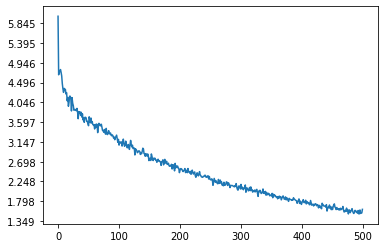

<Figure size 432x288 with 0 Axes>

In [9]:
#CODE
showPlot(plot_losses,name=model_name)

In [25]:
# Name Weights
filename_weights_encoder = 'model_encoder_'+model_name
filename_weights_decoder = 'model_decoder_'+model_name

In [26]:
#save Weights
torch.save(encoder1, filename_weights_encoder)
torch.save(attn_decoder1, filename_weights_decoder)

In [9]:
# Reload weights
encoder1 = torch.load(filename_weights_encoder)
attn_decoder1 = torch.load(filename_weights_decoder)

In [32]:
plots=[]
lables=[]
#opt = optim.Adadelta   #viable
#opt = optim.Adagrad    #viable
#opt = optim.Adam       #viable
#opt = optim.AdamW      #viable
#opt = optim.SparseAdam #viable
#opt = optim.ASGD       #viable   
#opt = optim.LBFGS      #viable
#opt = optim.NAdam      #viable
#opt = optim.RAdam      #viable
#opt = optim.RMSprop    #viable
#opt = optim.Rprop      #viable
#opt=optim.SGD          #viable

'''
opts = [optim.Adadelta, optim.Adam, optim.AdamW,
        optim.ASGD, optim.NAdam, 
        optim.RAdam, optim.SGD]
       #issue with optim.SparseAdam, optim.LBFGS, optim.Rprop, optim.Adagrad
       #BAD: optim.RMSprop,
'''
#works[]
opts = [optim.Adam, optim.AdamW, optim.NAdam, optim.SGD]

#opts = [optim.Adam, optim.SGD] 
epochs=10000
print_every=50
plot_every=100
learning_rate=0.01
batch_size = 25
teacher_forcing_ratio = 0.5
hidden_size = 256
dropout = 0.01

for i in opts: #range(3):
    
    print('------'*8)
    #
    #lables.append(str(i/10))
    lables.append(i.__name__)
    print('Attribut: optimizer -',i.__name__)
    print('------'*8)
    
    #model info

    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=dropout).to(device)
    
    #train info
    plot_losses = trainIters(encoder1, attn_decoder1, 
                             n_iters=epochs, 
                             batch_size = batch_size,
                             print_every=print_every,
                             plot_every=plot_every, 
                             learning_rate=learning_rate/batch_size,
                             opt=i)
    showPlot(plot_losses,name=i.__name__)
    plots.append(plot_losses)

    
print('******'*8)
print('final results')
print('******'*8)
comparePlots(plots,lables)

------------------------------------------------
Attribut: optimizer - Adam
------------------------------------------------
epoch 50.000000 : 2m 24s (- 477m 41s) (50 0%) 5.2151
epoch 100.000000 : 4m 55s (- 486m 45s) (100 1%) 4.5280
epoch 150.000000 : 7m 26s (- 488m 44s) (150 1%) 4.4552
epoch 200.000000 : 10m 6s (- 495m 35s) (200 2%) 4.5557
epoch 250.000000 : 12m 46s (- 497m 54s) (250 2%) 4.4407
epoch 300.000000 : 15m 16s (- 494m 6s) (300 3%) 4.3341
epoch 350.000000 : 17m 48s (- 491m 3s) (350 3%) 4.2920
epoch 400.000000 : 20m 25s (- 490m 18s) (400 4%) 4.2372
epoch 450.000000 : 23m 0s (- 488m 8s) (450 4%) 4.0863
epoch 500.000000 : 25m 33s (- 485m 27s) (500 5%) 4.1177
epoch 550.000000 : 28m 9s (- 483m 50s) (550 5%) 4.1379
epoch 600.000000 : 30m 49s (- 482m 53s) (600 6%) 4.1853
epoch 650.000000 : 33m 25s (- 480m 54s) (650 6%) 4.0612
epoch 700.000000 : 36m 2s (- 478m 53s) (700 7%) 3.9867
epoch 750.000000 : 38m 43s (- 477m 36s) (750 7%) 3.9652
epoch 800.000000 : 41m 19s (- 475m 14s) (800 8%

KeyboardInterrupt: 

In [28]:
count=0
ind=[]
for i in plots:
    
    x = sum(i[40:])/len(i[40:])
    if x<3.5:
        print(x)
        print(count)
        ind.append(count)
    
    count+=1
    

3.4628065006372335
1
3.44206507887926
2
3.4206997854911374
4
3.487573026213848
6


In [30]:
opts = [optim.Adadelta, optim.Adam, optim.AdamW,
        optim.ASGD, optim.NAdam, 
        optim.RAdam, optim.SGD]
for i in d

optim.Adam,optim.AdamW,optim.NAdam,optim.SGD

[1, 2, 4, 6]

In [27]:
import nltk
from nltk.translate.bleu_score import sentence_bleu 
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.chrf_score import sentence_chrf
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.translate.ribes_score import sentence_ribes
from nltk.tokenize import word_tokenize
nltk.download('wordnet') #reqired for meteor
import pickle
import string
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from tqdm import tqdm

[nltk_data] Downloading package wordnet to /home/ajs568/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
def Evaluate(reference, hypothesis, d):
    
    local=[]
    
    #BLEU structure
    #references -- (list(list(str))) – reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    
    average_bleu=[]
    
    #BLEU - Smoothing Method 1
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
        d['BLUE_m1'].append(min(score,1))
        local.append(['BLUE_m1',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m1',e])
        pass
        #d['BLUE_m1'].append(None)
    
    #BLEU - Smoothing Method 2
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method2)
        d['BLUE_m2'].append(min(score,1))
        local.append(['BLUE_m2',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m2',e])
        pass
        #d['BLUE_m2'].append(None)
        
    #BLEU - Smoothing Method 3
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method3)
        d['BLUE_m3'].append(min(score,1))
        local.append(['BLUE_m3',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m3',e])
        pass
        #d['BLUE_m3'].append(None)
    
    #BLEU - Smoothing Method 4
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method4)
        d['BLUE_m4'].append(min(score,1))
        local.append(['BLUE_m4',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m4',e])
        pass
        #d['BLUE_m4'].append(None)
    
    #BLEU - Smoothing Method 5
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method5)
        d['BLUE_m5'].append(min(score,1))
        local.append(['BLUE_m5',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m5',e])
        pass
        #d['BLUE_m5'].append(None)
        
    #BLEU - Smoothing Method 6
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method6)
        d['BLUE_m6'].append(min(score,1))
        local.append(['BLUE_m6',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m6',e])
        pass
        #d['BLUE_m6'].append(None)
        
    #BLEU - Smoothing Method 7
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method7)
        d['BLUE_m7'].append(min(score,1))
        local.append(['BLUE_m7',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m7',e])
        pass
        #d['BLUE_m7'].append(None)

        
    #AVERAGE OF BLEU SCORE
    try:
        score = sum(average_bleu)/len(average_bleu)
        d['BLUE'].append(score)
        local.append(['BLUE',score])
    except Exception as e:
        local.append(['BLUE',e])
        pass
    
    #CHRF
    #references (list(str) / str) – reference sentence
    #hypothesis (list(str) / str) – a hypothesis sentence
    chrf_reference = reference[0]
    chrf_hypothesis = hypothesis
    try:
        score = sentence_chrf(chrf_reference, chrf_hypothesis)
        d['CHRF'].append(min(score,1))
        local.append(['CHRF',min(score,1)])
    except Exception as e:
        local.append(['CHRF',e])
        pass
        #d['CHRF'].append(None)

    #GLUE
    #references (list(list(str))) – a list of reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    try:
        score = sentence_gleu(reference, hypothesis)
        d['GLUE'].append(min(score,1))
        local.append(['GLUE',min(score,1)])
    except Exception as e:
        local.append(['GLUE',e])
        pass
        #d['GLUE'].append(None)

    #METEOR
    #references (list(str)) – reference sentences 
    #hypothesis (str) – a hypothesis sentence
    meteor_reference = ' '.join(reference[0])
    meteor_hypothesis = ' '.join(hypothesis)
    try:
        score = single_meteor_score(meteor_reference, meteor_hypothesis)
        d['METEOR'].append(min(score,1))
        local.append(['METEOR',min(score,1)])
    except Exception as e:
        local.append(['METEOR',e])
        pass
        #d['METEOR'].append(None)

    #NIST -- excluded because not sure how to compare
    #references (list(list(str))) – reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    '''
    try:
        score = sentence_nist(reference, hypothesis)
        d['NIST'].append(score)
        local.append(['NIST',score])
    except Exception as e:
        local.append(['NIST',e])
        pass
        #d['NIST'].append(None)
    '''

    #RIBES
    #references (list(list(str))) - a list of reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    try:
        score = sentence_ribes(reference, hypothesis)
        d['RIBES'].append(min(score,1))
        local.append(['RIBES',min(score,1)])
    except Exception as e:
        local.append(['RIBES',e])
        pass
        #d['RIBES'].append(None)

    
    #print(local)

In [29]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_set)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
    
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
    
def evaluateAndShowMetrics(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_set)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence[:-6])
        print('scores')
        print(sentence_bleu([pair[1]], output_sentence[:-6]))
        print('')
        
def evaluateAndShowMetricTable(encoder, decoder, n=10):
    d={'BLUE':[],'BLUE_m1':[],'BLUE_m2':[],'BLUE_m3':[],'BLUE_m4':[],
       'BLUE_m5':[],'BLUE_m6':[],'BLUE_m7':[],'CHRF':[],
       'GLUE':[], 'METEOR':[],'NIST':[], 'RIBES':[]}
    
    for i in tqdm(range(n)):
        pair = random.choice(test_set)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        reference  = [pair[1]]
        hypothesis = output_sentence[:-6]
        Evaluate(reference,hypothesis,d)
        
    data = [d['BLUE'],d['CHRF'],d['GLUE'], d['METEOR'], d['RIBES']]

    fig = plt.figure(figsize =(10, 7)) 
    plt.xticks([1, 2, 3, 4,5], ['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])

    # Creating plot 
    plt.boxplot(data) 

    # show plot 
    plt.show() 
    
def wrong_answers_only(encoder, decoder, n=10, plot=True, side_by_side=True):
    d={'BLUE':[],'BLUE_m1':[],'BLUE_m2':[],'BLUE_m3':[],'BLUE_m4':[],
       'BLUE_m5':[],'BLUE_m6':[],'BLUE_m7':[],'CHRF':[],
       'GLUE':[], 'METEOR':[],'NIST':[], 'RIBES':[]}
    
    for i in tqdm(range(n)):
        pair = random.choice(test_set)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        
        BLEU = sentence_bleu([pair[1]], output_sentence[:-6])
        if BLEU<1:
            
            if side_by_side:
                print('>', pair[0])
                print('=', pair[1])
                print('<', output_sentence[:-6])
                print('BLEU:',BLEU)
                print('')

            reference  = [pair[1]]
            hypothesis = output_sentence[:-6]
            Evaluate(reference,hypothesis,d)
    
    if plot:    
        data = [d['BLUE'],d['CHRF'],d['GLUE'], d['METEOR'], d['RIBES']]

        fig = plt.figure(figsize =(10, 7)) 
        #plt.xticks([1, 2, 3, 4, 5], ['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])
        plt.xticks(['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])

        # Creating plot 
        plt.boxplot(data) 

        # show plot 
        plt.show() 

100%|███████████████████████████████████████| 1000/1000 [02:08<00:00,  7.77it/s]


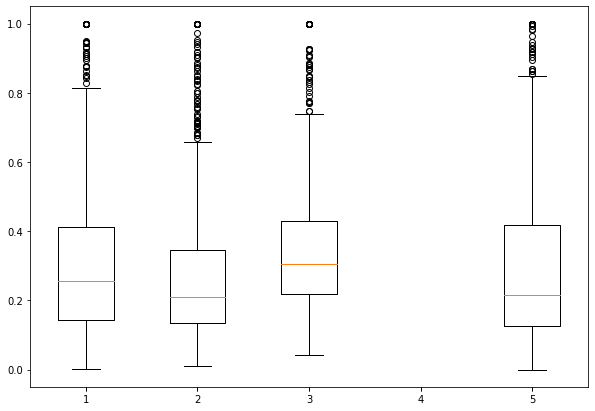

In [33]:
#evaluateRandomly(encoder1, attn_decoder1,n=1)
#evaluateAndShowMetrics(encoder1, attn_decoder1, n=1)
evaluateAndShowMetricTable(encoder1, attn_decoder1, n=1000)
#wrong_answers_only(encoder1, attn_decoder1, n=10, plot=False, side_by_side=True)

#run on user entered code segment
#evaluateAndShowAttention('''def run_sorting_algorithm(algorithm, array):''')


In [ ]:
#add histogram for blue score, just for kicks
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

#TODO

In [36]:
#on "test" data

#evaluateRandomly(encoder1, attn_decoder1)
#evaluateAndShowAttention(encoder1, attn_decoder1)

>     def append(self, track):
        
        self.tracks.append(track)


= append track to playlist .
< append track to playlist . <EOS>

>     def __contains__(self, name):
        
        return name in self.sections()


= return whether the configuration contains a section of the given name .
< returns true if the name is in the the name <EOS>

>     def toggle_use_vte_titles(self, chk):
        
        self.update_vte_subwidgets_states()


= when vte titles aren t used there is nothing to abbreviate
< vte vte aren aren and aren t aren <EOS>

>     def pop(self):
        
        return _coda_types.VectorSizeT_pop(self)



= pop vectorsizet self std vector size t value type
< pop vectorsizet self std vector size t value type <EOS>

> def has_params(params, filters):
  
  return any(params.get(fltr.param_key) for fltr in filters)



= check if there s any param .
< check if a is param . <EOS>

>     def to_json(self):
        
        return json.dumps(self.attributes)


= retur

input = def run_sorting_algorithm(algorithm, array):
output = update the python binary on parameters . <EOS>


/tmp/ipykernel_2542220/1353268929.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_2542220/1353268929.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


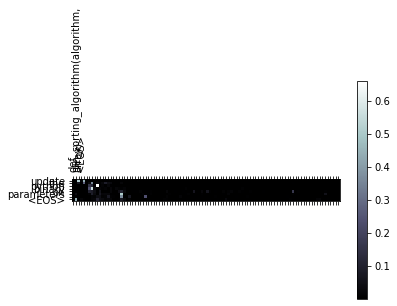

In [29]:
evaluateAndShowAttention('''def run_sorting_algorithm(algorithm, array):''')

input =     n = len(array)
    for i in range(n):
        already_sorted = True
        for j in range(n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]
                already_sorted = False
        if already_sorted:
            break
    return array
output = return the in bit bit with t in form and and and and and n in bits and x . <EOS>


/tmp/ipykernel_2542220/1353268929.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_2542220/1353268929.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


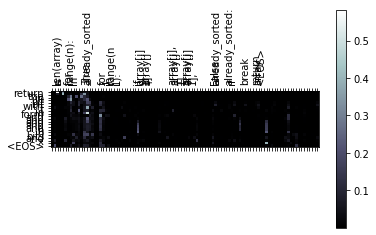

In [30]:
evaluateAndShowAttention('''    n = len(array)
    for i in range(n):
        already_sorted = True
        for j in range(n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]
                already_sorted = False
        if already_sorted:
            break
    return array''')